# XGBoost for sleep staging classification
We train an XGBoost model to automatically classify sleep staging for the two datasets.

Tree-based models can handle missing data nicely with the internal algorithms. They are also not affected by the variance of the features.

XGBoost has gained its reputation among machine learning competitions because of its speed and performance.

### Evaluation
We use 10-fold cross-validation for evalation of classifer's performance. Because of the imbalanced datasets, it is important to maintain the proportion of the class distribution for each fold. Scikit-learn provides a nice function called [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to implement this.

We use the performance metrics such as accuracy, precision, recall and F1-score

### Feature importance
One of benefits from XGBoost is that it can provide feature importance from the trained model. It is based on how frequent the feature is used to build the trees. The higher the more important. 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
# from sklearn.grid_search import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib


%matplotlib inline
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 20)
matplotlib.rcParams['figure.figsize'] = (8, 6)

/home/qfen8290/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# XGBoost classifier for subjects with Actigraphy data - dataset 1 with 20 subjects

## Load data

In [2]:
# df = pd.read_csv("./Input//svm_data_clean_160926.csv")
df = pd.read_csv("./Input/ins_subjects_161014.csv", index_col=0, parse_dates=True)

In [3]:
df.info(); df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19369 entries, 2015-09-09 20:47:01 to 2015-10-01 07:01:16
Data columns (total 21 columns):
Abdomen        19346 non-null float64
Activity       19365 non-null float64
Calf           18541 non-null float64
Chest          19361 non-null float64
Fingertip      19348 non-null float64
Foot           19336 non-null float64
Forearm        19356 non-null float64
Forehead       19361 non-null float64
HR_mean        17791 non-null float64
HR_stdev       17773 non-null float64
Hand           18303 non-null float64
Patient_id     19369 non-null object
ST_DPG         19352 non-null float64
ST_Distal      19352 non-null float64
ST_Proximal    19361 non-null float64
Scapula        19354 non-null float64
Staging        19369 non-null object
Toe            17933 non-null float64
Upperarm       19361 non-null float64
Upperleg       19342 non-null float64
White Light    19365 non-null float64
dtypes: float64(19), object(2)
memory usage: 3.3+ MB


,Abdomen,Activity,Calf,Chest,Fingertip,Foot,Forearm,Forehead,HR_mean,HR_stdev,...,Patient_id,ST_DPG,ST_Distal,ST_Proximal,Scapula,Staging,Toe,Upperarm,Upperleg,White Light
2015-09-09 20:47:01,33.8525,6.0,32.54225,32.87400,31.93225,34.49425,32.4790,34.5505,0.763625,0.083970,...,INS_WI_004,-0.086375,32.757625,32.671250,33.2430,SLEEP-S0,32.1250,32.4985,31.46000,5.30
2015-09-09 20:47:31,33.8525,27.0,32.54225,32.87400,31.93225,34.49425,32.4790,34.5505,0.757949,0.077656,...,INS_WI_004,-0.086375,32.757625,32.671250,33.2430,SLEEP-S0,32.1250,32.4985,31.46000,0.72
2015-09-09 20:48:01,33.9460,23.0,32.76025,32.96725,32.49375,34.72850,32.5415,34.5820,0.722714,0.068939,...,INS_WI_004,-0.402188,33.147563,32.745375,33.2745,SLEEP-S0,32.8265,32.5455,31.52275,0.59


In [3]:
df['Staging'].unique()

array(['SLEEP-S0', 'SLEEP-S1', 'SLEEP-S2', 'SLEEP-S3', 'SLEEP-REM'], dtype=object)

### Convert `Staging` to `0 (wake)` and `1 (sleep)`
**XGBoost can handle missing data in a nice manner**, so we don't need to use forward-filling to fill any missing data

In [4]:
df['Staging'] = df['Staging'].apply(lambda s: 0 if 'S0' in s else 1)
# df = df.ffill()
# df = df.bfill()
# df.dropna(inplace=True)

### Split data into training and test set

In [5]:
# df_act = df
y = df.Staging#.values
X = df.copy()
X.drop(['Patient_id', 'Staging'], axis=1, inplace=True)
# X.drop('Staging', axis=1, inplace=True)
#X = X.values

In [6]:
print(X.shape, y.shape)

(19369, 19) (19369,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(y_train.shape, y_test.shape)

(15495,) (3874,)


## Train XGBoost classifier with the optimal parameters

In [9]:
xgbclf1 = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.1, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=0.3)

In [10]:
xgbclf1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.3, seed=0, silent=True, subsample=0.8)

In [11]:
xgbclf1.score(X_train, y_train)

0.9984511132623427

In [22]:
y_pred1 = xgbclf1.predict(X_test)

In [24]:
y_pred1.dtype == 'float'

False

In [13]:
accuracy_score(y_test, y_pred1)

0.93236964377903975

In [14]:
precision_recall_fscore_support(y_test, y_pred1)

(array([ 0.83658171,  0.95229186]),
 array([ 0.78481013,  0.96553905]),
 array([ 0.80986938,  0.9588697 ]),
 array([ 711, 3163]))

In [15]:
print(classification_report(y_test, y_pred1))

             precision    recall  f1-score   support

          0       0.84      0.78      0.81       711
          1       0.95      0.97      0.96      3163

avg / total       0.93      0.93      0.93      3874



### Spot the most importance features 

In [16]:
xgbclf1.booster().get_fscore()

{'Abdomen': 1260,
 'Activity': 775,
 'Calf': 1693,
 'Chest': 1167,
 'Fingertip': 1395,
 'Foot': 1253,
 'Forearm': 1333,
 'Forehead': 1285,
 'HR_mean': 3182,
 'HR_stdev': 3433,
 'Hand': 1437,
 'ST_DPG': 1624,
 'ST_Distal': 1236,
 'ST_Proximal': 1160,
 'Scapula': 1345,
 'Toe': 1629,
 'Upperarm': 1317,
 'Upperleg': 1174,
 'White Light': 1169}

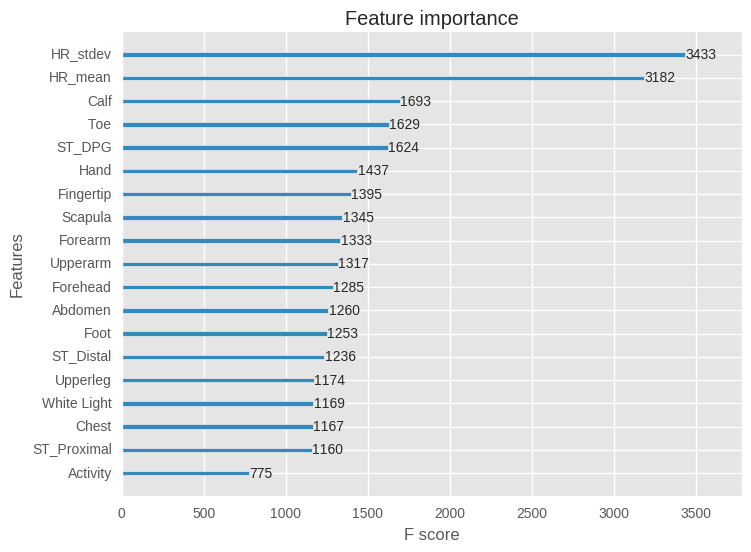

In [17]:
xgb.plot_importance(xgbclf1.booster())

Interestingly, **heart rate** features seems higher than the other features and activity is the least important one. That is why the performance of XGBoost doesn’t drop too much for the dataset of 59 subjects without Actigraphy data. It is the heart not your brain is the governor of your body in Traditional Chinese Medcine view.

## 10-fold cross validation

### Define a function to perform kfold cross validation

In [263]:
def kfold_cv(clf, df, num_fold=10):
    """
    Perform kfold cross-validation.
    Args:
        clf: classifier
        df: dataframe containing all the required data
        num_fold: kfold
    Return:
        a list of accuracy, precision, recall, f1 score for each cv
    """
    acc_list, pr_weighted_list, rec_weighted_list, f1_weighted_list = [], [], [], []
    TP, FP, TN, FN = [], [], [], []
    
    # remove any entry with unscored and covert to wake-sleep
    if df['Staging'].dtype == 'object':
        df = df[df['Staging'] != 'SLEEP-UNSCORED']
        df['Staging'] = df['Staging'].apply(lambda s: 0 if 'S0' in s else 1)
   
    if not isinstance(clf, xgb.sklearn.XGBClassifier):
        df = df.ffill()
        df = df.bfill()
        df.dropna(inplace=True)
    
    skf = model_selection.StratifiedKFold(num_fold, shuffle=True)        
    X = df.drop(['Patient_id', 'Staging'], axis=1)
    y = df['Staging']
     
    for train_ix, test_ix in skf.split(X, y):
        
        print("length of validation set:", len(test_ix))
#         print(df[df['Patient_id']!=sub_test]['Patient_id'].unique())
        y_test = y.iloc[test_ix]
        X_test = X.iloc[test_ix, :]
        y_train = y.iloc[train_ix]
        X_train = X.iloc[train_ix, :]

        if not isinstance(clf, xgb.sklearn.XGBClassifier):
            X_train = X_train.values 
            X_test = X_test.values
            y_train = y_train.values
            y_test = y_test.values
            
        # train the clf
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        # compute scores
        acc_list.append(accuracy_score(y_test, pred))
        pr_weighted_list.append(precision_score(y_test, pred, average='weighted'))
        rec_weighted_list.append(recall_score(y_test, pred, average='weighted'))
        f1_weighted_list.append(f1_score(y_test, pred, average='weighted'))

        cm = confusion_matrix(y_test, pred)
        TP.append(cm[1, 1])
        FP.append(cm[0, 1])
        TN.append(cm[0, 0])
        FN.append(cm[1, 0])
        
    cv_scores = pd.DataFrame({'Fold':[i for i in range(1, num_fold+1)], 'Accuracy':acc_list, 
                              'Precision_weighted': pr_weighted_list,
                              'Recall_weighted': rec_weighted_list, 'F1_weighted': f1_weighted_list,
                              'TP': TP, 'FP': FP, 'FN': FN, 'TN':TN})
    return cv_scores
            
#     return subjects, acc_list, prf_list1, prf_list2,cm

In [109]:
xgbclf = XGBClassifier(n_estimators=1500, max_depth=8, learning_rate=0.3, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.9)

kfold_scores = kfold_cv(xgbclf, df, num_fold=10)

length of validation set: 1938
length of validation set: 1938
length of validation set: 1938
length of validation set: 1937
length of validation set: 1937
length of validation set: 1937
length of validation set: 1936
length of validation set: 1936
length of validation set: 1936
length of validation set: 1936


In [26]:

kfold_scores = pd.read_csv("./xgb_10fold_cv_scores_20subjects.csv", index_col=0)
kfold_scores

,Accuracy,F1_weighted,FN,FP,Fold,Precision_weighted,Recall_weighted,TN,TP
0,0.938596,0.937763,47,72,1,0.937417,0.938596,297,1522
1,0.925181,0.924079,59,86,2,0.923528,0.925181,283,1510
2,0.930857,0.929719,52,82,3,0.929276,0.930857,287,1517
3,0.936500,0.935344,45,78,4,0.935048,0.936500,291,1523
4,0.932370,0.930315,39,92,5,0.930546,0.932370,277,1529
5,0.933918,0.932520,45,83,6,0.932265,0.933918,286,1523
6,0.930785,0.929562,51,83,7,0.929134,0.930785,285,1517
7,0.935434,0.933465,36,89,8,0.933808,0.935434,279,1532
8,0.933884,0.933096,53,75,9,0.932680,0.933884,293,1515
9,0.936983,0.936513,54,68,10,0.936191,0.936983,300,1514


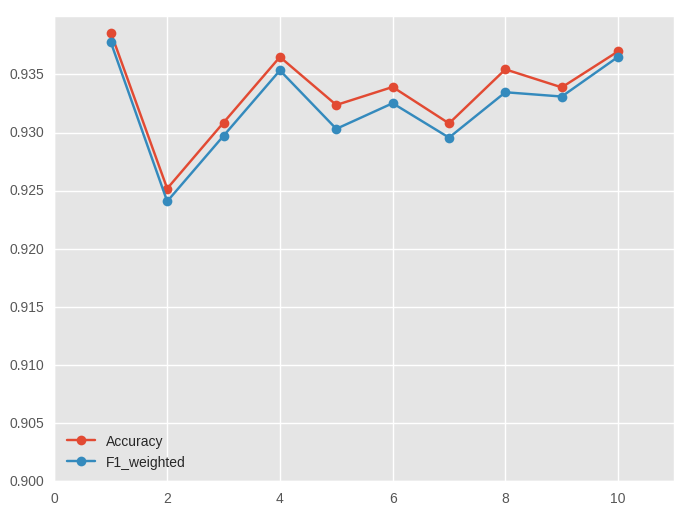

In [276]:
plt.plot(kfold_scores['Fold'], kfold_scores['Accuracy'], '-o')
plt.plot(kfold_scores['Fold'], kfold_scores['F1_weighted'], '-o')
# plt.plot(kfold_scores['Fold'], kfold_scores['Recall_weighted'], '-o')
plt.xlim(0, kfold_scores.shape[0]+1)
plt.ylim(0.90, 0.94)
plt.legend(loc=0)
# kfold_scores.plot.scatter(x=kfold_scores.index, y='Accuarcy')
plt.show()

# XGBoost classifier for subjects without Actigraphy data - dataset 2 with 59 subjects

In [257]:
df2 = pd.read_csv("./Input/ins_subjects_no_act_161016.csv", index_col=0, parse_dates=True)
df2.info(); df2.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56174 entries, 2015-09-02 22:49:52 to 2015-10-01 07:01:16
Data columns (total 19 columns):
Abdomen        56142 non-null float64
Calf           54484 non-null float64
Chest          56157 non-null float64
Fingertip      55253 non-null float64
Foot           56132 non-null float64
Forearm        55457 non-null float64
Forehead       55382 non-null float64
HR_mean        53119 non-null float64
HR_stdev       53081 non-null float64
Hand           53307 non-null float64
Patient_id     56174 non-null object
ST_DPG         56148 non-null float64
ST_Distal      56148 non-null float64
ST_Proximal    56157 non-null float64
Scapula        55310 non-null float64
Staging        56174 non-null object
Toe            53836 non-null float64
Upperarm       54214 non-null float64
Upperleg       53331 non-null float64
dtypes: float64(17), object(2)
memory usage: 8.6+ MB


,Abdomen,Calf,Chest,Fingertip,Foot,Forearm,Forehead,HR_mean,HR_stdev,Hand,Patient_id,ST_DPG,ST_Distal,ST_Proximal,Scapula,Staging,Toe,Upperarm,Upperleg
2015-09-02 22:49:52,35.45875,35.45875,33.934,31.40175,35.45875,33.934,33.81725,0.911394,0.071224,32.90025,INS_WI_001,0.510312,33.804875,34.315187,33.934,SLEEP-S0,35.45875,33.934,33.934
2015-09-02 22:50:22,35.45875,35.45875,34.059,31.41750,35.45875,34.059,33.81725,0.885559,0.020428,32.83775,INS_WI_001,0.615750,33.793187,34.408937,34.059,SLEEP-S0,35.45875,34.059,34.059
2015-09-02 22:50:52,35.45875,35.45875,34.059,31.41750,35.45875,34.059,33.81725,0.855143,0.066847,32.83775,INS_WI_001,0.615750,33.793187,34.408937,34.059,SLEEP-S0,35.45875,34.059,34.059


In [294]:
len(df2['Patient_id'].unique())

59

### remove any entry with unscored and covert to wake-sleep

In [295]:
df2 = df2[df2['Staging']!='SLEEP-UNSCORED']

In [296]:
df2[df2['Staging']=='SLEEP-UNSCORED']['Patient_id'].unique()

array([], dtype=object)

In [297]:
df2['Staging'] = df2['Staging'].apply(lambda s: 0 if 'S0' in s else 1)
df2.shape

(55913, 19)

In [141]:
y = df2.Staging#.values
X = df2.copy()
X.drop('Staging', axis=1, inplace=True)
X.drop('Patient_id', axis=1, inplace=True)
#X = X.values

In [184]:
print(X.shape, y.shape)

(55913, 17) (55913,)


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(y_train.shape, y_test.shape)

(44730,) (11183,)


## Train XGBoost classifier with the optimal parameters

In [185]:
xgbclf3 = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.1, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=0.3)

In [228]:
xgbclf3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.3, seed=0, silent=True, subsample=0.8)

In [229]:
xgbclf3.score(X_train, y_train)

0.98598256203890011

In [230]:
y_pred3 = xgbclf3.predict(X_test)

In [191]:
y_pred_prob3 = xgbclf3.predict_proba(X_test)

In [192]:
y_pred_prob3

array([[ 0.06018609,  0.93981391],
       [ 0.00716877,  0.99283123],
       [ 0.06549108,  0.93450892],
       ..., 
       [ 0.05943495,  0.94056505],
       [ 0.01555103,  0.98444897],
       [ 0.91095185,  0.08904817]], dtype=float32)

In [231]:
accuracy_score(y_test, y_pred3)

0.9027988911741035

In [232]:
precision_recall_fscore_support(y_test, y_pred3, average='weighted')

(0.90315020991403161, 0.9027988911741035, 0.90296615490400289, None)

In [233]:
print(classification_report(y_test, y_pred3, digits=5))

             precision    recall  f1-score   support

          0    0.80928   0.81793   0.81358      2900
          1    0.93602   0.93251   0.93426      8283

avg / total    0.90315   0.90280   0.90297     11183



### Spot the most importance features 

In [ ]:
xgbclf3.booster().get_fscore()

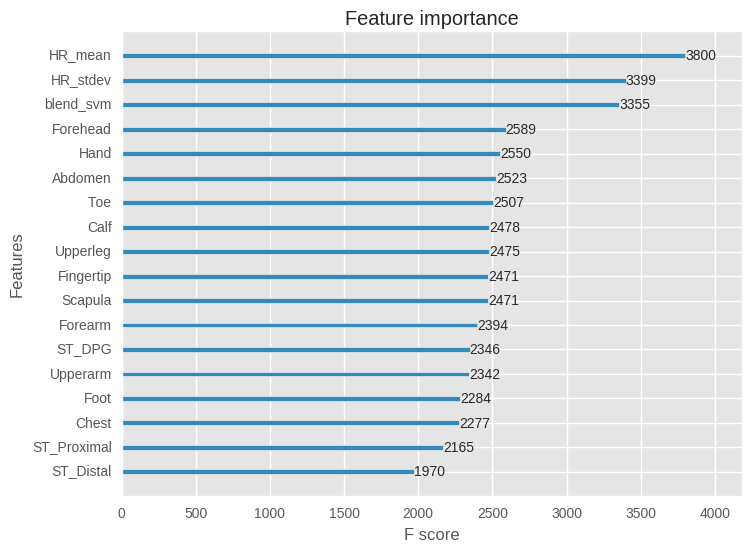

In [234]:
xgb.plot_importance(xgbclf3.booster())

## 10-fold cross validation

In [151]:
xgbclf = XGBClassifier(n_estimators=1500, max_depth=8, learning_rate=0.3, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.9)

kfold_scores2 = kfold_cv(xgbclf, df2, num_fold=10)

length of validation set: 5593
length of validation set: 5592
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591
length of validation set: 5591


In [27]:

kfold_scores2 = pd.read_csv("./xgb_10fold_cv_scores_59subjects.csv", index_col=0)
kfold_scores2

,Accuracy,F1_weighted,FN,FP,Fold,Precision_weighted,Recall_weighted,TN,TP
0,0.919721,0.918022,139,310,1,0.918602,0.919721,1142,4002
1,0.922210,0.920938,150,285,2,0.921070,0.922210,1167,3990
2,0.919156,0.917843,159,293,3,0.917905,0.919156,1158,3981
3,0.917009,0.915855,174,290,4,0.915719,0.917009,1161,3966
4,0.917009,0.915574,161,303,5,0.915683,0.917009,1148,3979
5,0.921302,0.920446,174,266,6,0.920230,0.921302,1185,3966
6,0.914684,0.913530,182,295,7,0.913337,0.914684,1156,3958
7,0.918083,0.917089,178,280,8,0.916880,0.918083,1171,3962
8,0.915221,0.913998,177,297,9,0.913863,0.915221,1154,3963
9,0.916294,0.915194,179,289,10,0.915006,0.916294,1162,3961


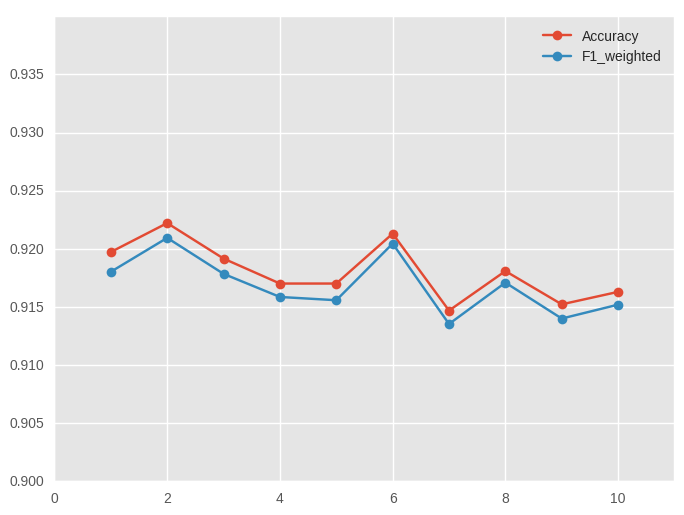

In [281]:
plt.plot(kfold_scores2['Fold'], kfold_scores2['Accuracy'], '-o')
plt.plot(kfold_scores2['Fold'], kfold_scores2['F1_weighted'], '-o')
# plt.plot(kfold_scores['Fold'], kfold_scores['Recall_weighted'], '-o')
plt.xlim(0, kfold_scores2.shape[0]+1)
plt.ylim(0.90, 0.94)
plt.legend(loc=0)
# kfold_scores.plot.scatter(x=kfold_scores.index, y='Accuarcy')
plt.show()